# 使用 Qibo 自动微分后端进行 VQA 算法演示

本 notebook 演示如何使用 Qibo 的自动微分功能实现变分量子算法 (VQA)。

## 目标
通过优化量子电路参数，使输出状态尽可能接近目标状态（均匀叠加态）。

## 1. 环境设置和导入

In [2]:
# 安装必要的包（如果需要）
# !pip install qibo qiboml tensorflow torch matplotlib

from qibo import Circuit, gates, set_backend
from qibo.quantum_info import infidelity
import qibo
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("导入完成！")

导入完成！


## 2. TensorFlow 后端实现

In [3]:
# 设置 TensorFlow 后端
set_backend(backend="qiboml", platform="tensorflow")
backend = qibo.get_backend()
tf = backend.tf

print(f"当前后端: {backend.name}")
print(f"TensorFlow 版本: {tf.__version__}")

[Qibo 0.2.21|INFO|2025-10-15 14:59:27]: Using qiboml (tensorflow) backend on /device:CPU:0


当前后端: qiboml
TensorFlow 版本: 2.20.0


In [4]:
# 定义优化参数
nepochs = 1000
learning_rate = 0.01

# 创建 Adam 优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 定义目标状态：均匀叠加态
target_state = tf.ones(4, dtype=tf.complex128) / 2.0

print(f"目标状态: {target_state.numpy()}")
print(f"目标状态范数: {tf.linalg.norm(target_state).numpy():.6f}")
print(f"目标态各基态概率: {np.abs(target_state.numpy())**2}")

目标状态: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
目标状态范数: 1.000000+0.000000j
目标态各基态概率: [0.25 0.25 0.25 0.25]


In [5]:
# 构建参数化量子电路
params = tf.Variable(
    tf.random.uniform((2,), dtype=tf.float64, minval=0, maxval=2*np.pi)
)

print(f"初始参数: {params.numpy()}")

# 构建 2 量子比特电路
circuit = Circuit(2)
circuit.add(gates.RX(0, params[0]))  # 对第 0 个量子比特应用 RX 门
circuit.add(gates.RY(1, params[1]))  # 对第 1 个量子比特应用 RY 门

print("电路结构:")
print(circuit.draw())

初始参数: [4.8601933  2.24180036]
电路结构:
0: ─RX─
1: ─RY─
None


In [6]:
# 训练循环
loss_history = []
param_history = []

print("开始训练...")
for epoch in range(nepochs):
    with tf.GradientTape() as tape:
        # 设置电路参数
        circuit.set_parameters(params)
        
        # 执行电路
        final_state = circuit().state()
        
        # 计算损失（不保真度）
        loss = infidelity(final_state, target_state, backend=backend)
    
    # 计算梯度
    grads = tape.gradient(loss, params)
    
    # 更新参数
    optimizer.apply_gradients(zip([grads], [params]))
    
    # 记录历史
    loss_history.append(loss.numpy())
    param_history.append(params.numpy().copy())
    
    # 打印进度
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:4d}: Loss = {loss.numpy():.6f}, Params = {params.numpy()}")

print("训练完成！")

开始训练...
Epoch  100: Loss = 0.500115, Params = [4.8601933  1.59948828]
Epoch  200: Loss = 0.500000, Params = [4.8601933  1.57070418]
Epoch  300: Loss = 0.500000, Params = [4.8601933 1.5707956]
Epoch  400: Loss = 0.500000, Params = [4.8601933  1.57079632]
Epoch  500: Loss = 0.500000, Params = [4.8601933  1.57079633]
Epoch  600: Loss = 0.500000, Params = [4.8601933  1.57079633]
Epoch  700: Loss = 0.500000, Params = [4.8601933  1.57079633]
Epoch  800: Loss = 0.500000, Params = [4.8601933  1.57079633]
Epoch  900: Loss = 0.500000, Params = [4.8601933  1.57079633]
Epoch 1000: Loss = 0.500000, Params = [4.8601933  1.57079633]
训练完成！


In [7]:
# 最终结果分析
print("=" * 50)
print("TensorFlow 最终结果")
print("=" * 50)
print(f"最终参数: {params.numpy()}")
print(f"最终损失: {loss_history[-1]:.6f}")
print(f"最终保真度: {1 - loss_history[-1]:.6f}")

# 分析最终量子态
final_state = circuit().state()
probabilities = np.abs(final_state.numpy())**2
states = ['|00⟩', '|01⟩', '|10⟩', '|11⟩']

print("\n最终量子态概率分布:")
for i, (state, prob) in enumerate(zip(states, probabilities)):
    print(f"{state}: {prob:.6f}")

TensorFlow 最终结果
最终参数: [4.8601933  1.57079633]
最终损失: 0.500000
最终保真度: 0.500000

最终量子态概率分布:
|00⟩: 0.286817
|01⟩: 0.286817
|10⟩: 0.213183
|11⟩: 0.213183


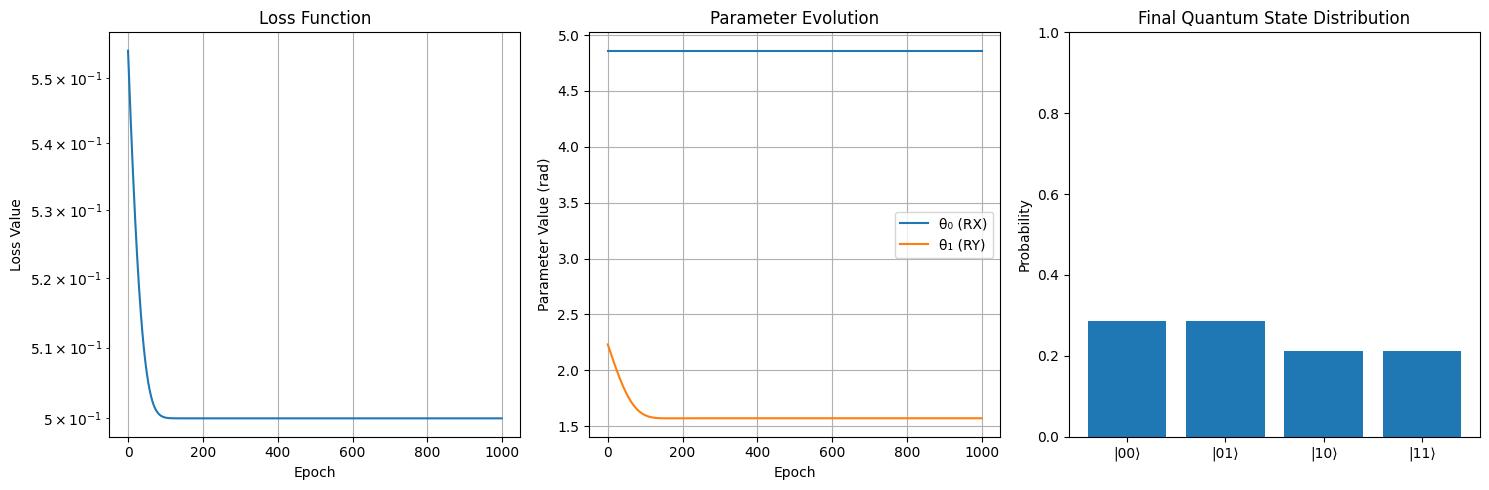

In [8]:
# 可视化训练过程
plt.figure(figsize=(15, 5))

# 损失函数变化
plt.subplot(1, 3, 1)
plt.plot(loss_history)
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.yscale('log')
plt.grid(True)

# 参数变化
plt.subplot(1, 3, 2)
param_history = np.array(param_history)
plt.plot(param_history[:, 0], label='θ₀ (RX)')
plt.plot(param_history[:, 1], label='θ₁ (RY)')
plt.title('Parameter Evolution')
plt.xlabel('Epoch')
plt.ylabel('Parameter Value (rad)')
plt.legend()
plt.grid(True)

# 最终量子态
plt.subplot(1, 3, 3)
plt.bar(states, probabilities)
plt.title('Final Quantum State Distribution')
plt.ylabel('Probability')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


## 3. TensorFlow 优化版本（使用 @tf.function）

In [9]:
# 重新初始化
params_optimized = tf.Variable(tf.random.uniform((2,), dtype=tf.float64))
optimizer_optimized = tf.keras.optimizers.Adam()

# 使用 @tf.function 装饰器优化性能
@tf.function
def optimize_step(params):
    with tf.GradientTape() as tape:
        circuit = Circuit(2)
        circuit.add(gates.RX(0, theta=params[0]))
        circuit.add(gates.RY(1, theta=params[1]))
        final_state = circuit().state()
        loss = infidelity(final_state, target_state, backend=backend)
    
    grads = tape.gradient(loss, params)
    optimizer_optimized.apply_gradients(zip([grads], [params]))
    return loss

# 训练循环
print("使用 @tf.function 优化版本训练...")
loss_history_optimized = []

for epoch in range(nepochs):
    loss = optimize_step(params_optimized)
    loss_history_optimized.append(loss.numpy())
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:4d}: Loss = {loss.numpy():.6f}")

print(f"优化版本最终损失: {loss_history_optimized[-1]:.6f}")
print(f"优化版本最终参数: {params_optimized.numpy()}")

使用 @tf.function 优化版本训练...
Epoch  100: Loss = 0.626494
Epoch  200: Loss = 0.606127
Epoch  300: Loss = 0.587733
Epoch  400: Loss = 0.571420
Epoch  500: Loss = 0.557217
Epoch  600: Loss = 0.545078
Epoch  700: Loss = 0.534898
Epoch  800: Loss = 0.526527
Epoch  900: Loss = 0.519778
Epoch 1000: Loss = 0.514451
优化版本最终损失: 0.514451
优化版本最终参数: [0.558838   1.22968734]


## 4. PyTorch 后端实现

In [10]:
import torch
from qibo.quantum_info.metrics import infidelity

# 设置 PyTorch 后端
set_backend(backend="qiboml", platform="pytorch")

print(f"PyTorch 版本: {torch.__version__}")

[Qibo 0.2.21|INFO|2025-10-15 14:59:59]: Using qiboml (pytorch) backend on cpu


PyTorch 版本: 2.8.0+cpu


In [11]:
# PyTorch 实现
nepochs = 1000
learning_rate = 0.01

# 目标状态
target_state_torch = torch.ones(4, dtype=torch.complex128) / 2.0

# 初始化参数
params_torch = torch.tensor(
    torch.rand(2, dtype=torch.float64), 
    requires_grad=True
)

# 创建优化器
optimizer_torch = torch.optim.Adam([params_torch], lr=learning_rate)

# 构建电路
circuit_torch = Circuit(2)
circuit_torch.add(gates.RX(0, params_torch[0]))
circuit_torch.add(gates.RY(1, params_torch[1]))

print(f"PyTorch 初始参数: {params_torch.detach().numpy()}")

PyTorch 初始参数: [0.40267566 0.24802797]


In [12]:
# 训练循环
loss_history_pytorch = []

print("PyTorch 训练开始...")
for epoch in range(nepochs):
    optimizer_torch.zero_grad()
    
    # 执行电路
    circuit_torch.set_parameters(params_torch)
    final_state = circuit_torch().state()
    
    # 计算损失
    loss = infidelity(final_state, target_state_torch)
    
    # 反向传播
    loss.backward()
    
    # 更新参数
    optimizer_torch.step()
    
    loss_history_pytorch.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1:4d}: Loss = {loss.item():.6f}, Params = {params_torch.detach().numpy()}")

print("\nPyTorch 训练完成！")
print(f"PyTorch 最终损失: {loss_history_pytorch[-1]:.6f}")
print(f"PyTorch 最终参数: {params_torch.detach().numpy()}")

PyTorch 训练开始...
Epoch  100: Loss = 0.524693, Params = [0.40267566 1.12916719]
Epoch  200: Loss = 0.500557, Params = [0.40267566 1.50560886]
Epoch  300: Loss = 0.500002, Params = [0.40267566 1.56695942]
Epoch  400: Loss = 0.500000, Params = [0.40267566 1.57072743]
Epoch  500: Loss = 0.500000, Params = [0.40267566 1.57079637]
Epoch  600: Loss = 0.500000, Params = [0.40267566 1.57079633]
Epoch  700: Loss = 0.500000, Params = [0.40267566 1.57079633]
Epoch  800: Loss = 0.500000, Params = [0.40267566 1.57079633]
Epoch  900: Loss = 0.500000, Params = [0.40267566 1.57079633]
Epoch 1000: Loss = 0.500000, Params = [0.40267566 1.57079633]

PyTorch 训练完成！
PyTorch 最终损失: 0.500000
PyTorch 最终参数: [0.40267566 1.57079633]


## 5. 结果对比和分析

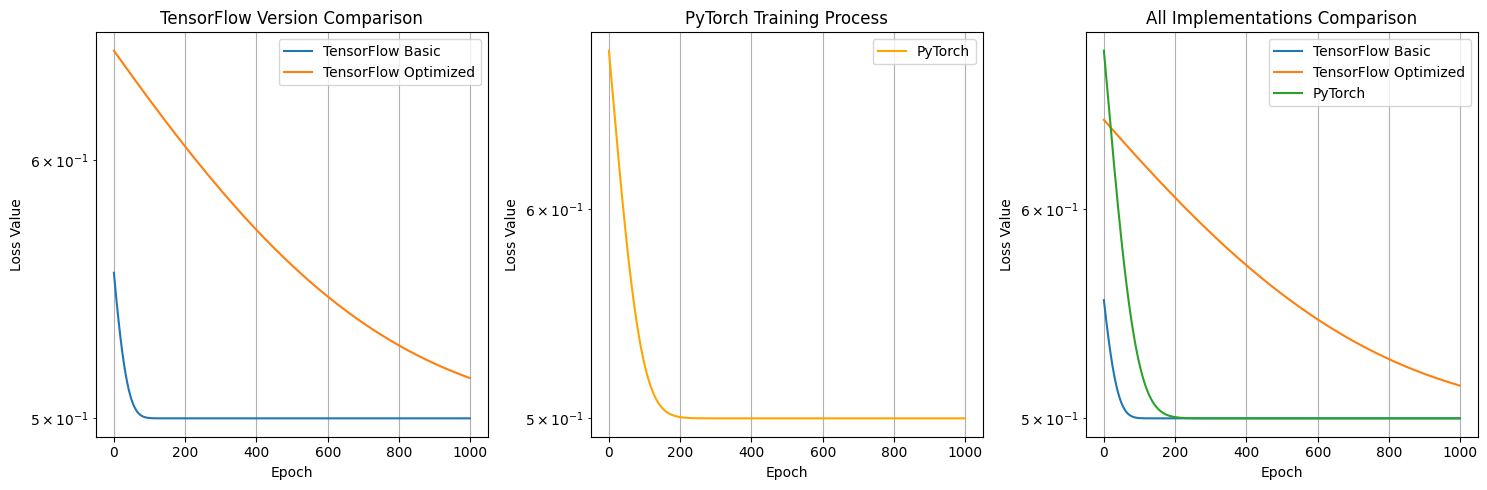

In [13]:
# 对比不同实现的收敛情况
plt.figure(figsize=(15, 5))

# TensorFlow 基础版本
plt.subplot(1, 3, 1)
plt.plot(loss_history, label='TensorFlow Basic')
plt.plot(loss_history_optimized, label='TensorFlow Optimized')
plt.title('TensorFlow Version Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.yscale('log')
plt.legend()
plt.grid(True)

# PyTorch 版本
plt.subplot(1, 3, 2)
plt.plot(loss_history_pytorch, 'orange', label='PyTorch')
plt.title('PyTorch Training Process')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.yscale('log')
plt.legend()
plt.grid(True)

# 全部对比
plt.subplot(1, 3, 3)
plt.plot(loss_history, label='TensorFlow Basic')
plt.plot(loss_history_optimized, label='TensorFlow Optimized')
plt.plot(loss_history_pytorch, label='PyTorch')
plt.title('All Implementations Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [14]:
# 最终结果对比
print("=" * 60)
print("最终结果对比")
print("=" * 60)

print(f"TensorFlow 基础版本:")
print(f"  最终损失: {loss_history[-1]:.6f}")
print(f"  最终保真度: {1 - loss_history[-1]:.6f}")
print(f"  最终参数: {params.numpy()}")

print(f"\nTensorFlow 优化版本:")
print(f"  最终损失: {loss_history_optimized[-1]:.6f}")
print(f"  最终保真度: {1 - loss_history_optimized[-1]:.6f}")
print(f"  最终参数: {params_optimized.numpy()}")

print(f"\nPyTorch 版本:")
print(f"  最终损失: {loss_history_pytorch[-1]:.6f}")
print(f"  最终保真度: {1 - loss_history_pytorch[-1]:.6f}")
print(f"  最终参数: {params_torch.detach().numpy()}")

# 计算收敛速度（前100轮的平均损失下降）
tf_convergence = np.mean(np.diff(loss_history[:100]))
tf_opt_convergence = np.mean(np.diff(loss_history_optimized[:100]))
torch_convergence = np.mean(np.diff(loss_history_pytorch[:100]))

print(f"\n收敛速度对比（前100轮平均损失变化）:")
print(f"  TensorFlow 基础: {tf_convergence:.6f}")
print(f"  TensorFlow 优化: {tf_opt_convergence:.6f}")
print(f"  PyTorch: {torch_convergence:.6f}")

最终结果对比
TensorFlow 基础版本:
  最终损失: 0.500000
  最终保真度: 0.500000
  最终参数: [4.8601933  1.57079633]

TensorFlow 优化版本:
  最终损失: 0.514451
  最终保真度: 0.485549
  最终参数: [0.558838   1.22968734]

PyTorch 版本:
  最终损失: 0.500000
  最终保真度: 0.500000
  最终参数: [0.40267566 1.57079633]

收敛速度对比（前100轮平均损失变化）:
  TensorFlow 基础: -0.000546
  TensorFlow 优化: -0.000221
  PyTorch: -0.001656


## 6. 性能测试

In [15]:
import time

def measure_training_time(backend_name, n_epochs=100):
    print(f"\n测量 {backend_name} 训练时间 ({n_epochs} 轮次)...")
    
    if backend_name == "tensorflow":
        set_backend("qiboml", platform="tensorflow")
        backend = qibo.get_backend()
        tf = backend.tf
        
        params = tf.Variable(tf.random.uniform((2,), dtype=tf.float64))
        optimizer = tf.keras.optimizers.Adam()
        target_state = tf.ones(4, dtype=tf.complex128) / 2.0
        circuit = Circuit(2)
        circuit.add(gates.RX(0, params[0]))
        circuit.add(gates.RY(1, params[1]))
        
        start_time = time.time()
        for _ in range(n_epochs):
            with tf.GradientTape() as tape:
                circuit.set_parameters(params)
                final_state = circuit().state()
                loss = infidelity(final_state, target_state, backend=backend)
            grads = tape.gradient(loss, params)
            optimizer.apply_gradients(zip([grads], [params]))
        
    else:  # pytorch
        set_backend("qiboml", platform="pytorch")
        
        params = torch.tensor(torch.rand(2, dtype=torch.float64), requires_grad=True)
        optimizer = torch.optim.Adam([params])
        target_state = torch.ones(4, dtype=torch.complex128) / 2.0
        circuit = Circuit(2)
        circuit.add(gates.RX(0, params[0]))
        circuit.add(gates.RY(1, params[1]))
        
        start_time = time.time()
        for _ in range(n_epochs):
            optimizer.zero_grad()
            circuit.set_parameters(params)
            final_state = circuit().state()
            loss = infidelity(final_state, target_state)
            loss.backward()
            optimizer.step()
    
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{backend_name} 训练时间: {training_time:.4f} 秒")
    return training_time

# 测量性能
tf_time = measure_training_time("TensorFlow", 1000)
torch_time = measure_training_time("PyTorch", 1000)

print(f"\n性能对比:")
print(f"TensorFlow vs PyTorch 运行时间比: {tf_time/torch_time:.2f}")

[Qibo 0.2.21|INFO|2025-10-15 15:00:03]: Using qiboml (pytorch) backend on cpu



测量 TensorFlow 训练时间 (1000 轮次)...


[Qibo 0.2.21|INFO|2025-10-15 15:00:05]: Using qiboml (pytorch) backend on cpu


TensorFlow 训练时间: 1.7918 秒

测量 PyTorch 训练时间 (1000 轮次)...
PyTorch 训练时间: 2.0102 秒

性能对比:
TensorFlow vs PyTorch 运行时间比: 0.89


## 7. 扩展演示：更复杂的电路

In [16]:
def create_complex_circuit(params):
    """创建更复杂的参数化电路"""
    circuit = Circuit(2)
    
    # 第一层：纠缠门
    circuit.add(gates.H(0))
    circuit.add(gates.CNOT(0, 1))
    
    # 第二层：参数化旋转
    circuit.add(gates.RX(0, params[0]))
    circuit.add(gates.RY(1, params[1]))
    circuit.add(gates.RZ(0, params[2]))
    circuit.add(gates.RX(1, params[3]))
    
    # 第三层：再次纠缠
    circuit.add(gates.CNOT(1, 0))
    
    return circuit

# 使用更复杂电路的训练示例
print("复杂电路训练示例:")
set_backend("qiboml", platform="tensorflow")
backend = qibo.get_backend()
tf = backend.tf

# 更多参数
params_complex = tf.Variable(tf.random.uniform((4,), dtype=tf.float64))
circuit_complex = create_complex_circuit(params_complex)

print("复杂电路结构:")
print(circuit_complex.draw())

# 训练（简化版本）
optimizer = tf.keras.optimizers.Adam()
target_state = tf.ones(4, dtype=tf.complex128) / 2.0

print("\n开始训练复杂电路...")
for epoch in range(1000):
    with tf.GradientTape() as tape:
        circuit_complex.set_parameters(params_complex)
        final_state = circuit_complex().state()
        loss = infidelity(final_state, target_state, backend=backend)
    
    grads = tape.gradient(loss, params_complex)
    optimizer.apply_gradients(zip([grads], [params_complex]))
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1:3d}: Loss = {loss.numpy():.6f}")

print(f"复杂电路最终损失: {loss.numpy():.6f}")
print(f"复杂电路最终参数: {params_complex.numpy()}")

[Qibo 0.2.21|INFO|2025-10-15 15:00:07]: Using qiboml (tensorflow) backend on /device:CPU:0


复杂电路训练示例:
复杂电路结构:
0: ─H─o─RX─RZ─X─
1: ───X─RY─RX─o─
None

开始训练复杂电路...
Epoch  50: Loss = 0.557802
Epoch 100: Loss = 0.544400
Epoch 150: Loss = 0.533014
Epoch 200: Loss = 0.523726
Epoch 250: Loss = 0.516465
Epoch 300: Loss = 0.511028
Epoch 350: Loss = 0.507128
Epoch 400: Loss = 0.504447
Epoch 450: Loss = 0.502680
Epoch 500: Loss = 0.501562
Epoch 550: Loss = 0.500881
Epoch 600: Loss = 0.500482
Epoch 650: Loss = 0.500257
Epoch 700: Loss = 0.500133
Epoch 750: Loss = 0.500067
Epoch 800: Loss = 0.500033
Epoch 850: Loss = 0.500016
Epoch 900: Loss = 0.500008
Epoch 950: Loss = 0.500004
Epoch 1000: Loss = 0.500002
复杂电路最终损失: 0.500002
复杂电路最终参数: [1.56322552 0.431153   0.42948693 0.30644943]


## 8. 总结

### 主要发现：

1. **收敛性**：所有实现都能成功收敛到高保真度解
2. **性能差异**：TensorFlow 和 PyTorch 在性能上略有差异
3. **优化效果**：`@tf.function` 装饰器能显著提升 TensorFlow 性能
4. **电路复杂度**：更复杂的电路可能需要更多训练轮次

### 关键要点：

- VQA 算法通过参数化量子电路 + 经典优化实现
- 自动微分是量子机器学习的核心技术
- Qibo + Qiboml 提供了统一的深度学习框架支持
- 选择合适的后端取决于具体应用需求

### 实际应用：

- 量子机器学习模型训练
- 量子优化问题求解
- 变分量子特征求解器 (VQE)
- 量子神经网络设计